In [1]:
!pip install -q findspark

In [1]:
from pyspark.sql import SparkSession
name="Dog_food_prediction"

spark= SparkSession.builder.appName(name).master("local[*]").getOrCreate()

24/11/21 15:33:05 WARN Utils: Your hostname, MacBook-Pro-de-Jaime.local resolves to a loopback address: 127.0.0.1; using 10.170.18.13 instead (on interface en0)
24/11/21 15:33:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/21 15:33:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/11/21 15:33:08 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
spark

In [2]:
dog_food="/Users/jaimecastro/Desktop/master/BIG_DATA/dog_food/dog_food.csv"
food_df= spark.read.format("csv")\
                            .options(header=True, inferschema=True, delimiter=",") \
                            .load(dog_food)

In [5]:
food_df.printSchema()

root
 |-- A: integer (nullable = true)
 |-- B: integer (nullable = true)
 |-- C: double (nullable = true)
 |-- D: integer (nullable = true)
 |-- Spoiled: double (nullable = true)



In [6]:
food_df.toPandas().describe()

,A,B,C,D,Spoiled
count,490.000000,490.000000,490.000000,490.000000,490.000000
mean,5.534694,5.504082,9.126531,5.579592,0.285714
std,2.951520,2.853797,2.055545,2.854837,0.452216
min,1.000000,1.000000,5.000000,1.000000,0.000000
25%,3.000000,3.000000,8.000000,3.000000,0.000000
50%,5.000000,6.000000,9.000000,6.000000,0.000000
75%,8.000000,8.000000,11.000000,8.000000,1.000000
max,10.000000,10.000000,14.000000,10.000000,1.000000


In [7]:
food_df.toPandas().head()

,A,B,C,D,Spoiled
0,4,2,12.0,3,1.0
1,5,6,12.0,7,1.0
2,6,2,13.0,6,1.0
3,4,2,12.0,1,1.0
4,4,2,12.0,3,1.0


In [8]:
food_df.toPandas().tail()

,A,B,C,D,Spoiled
485,8,3,6.0,6,0.0
486,6,4,9.0,10,0.0
487,1,3,8.0,3,0.0
488,6,6,8.0,3,0.0
489,1,9,7.0,4,0.0


# EDA

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Histogram

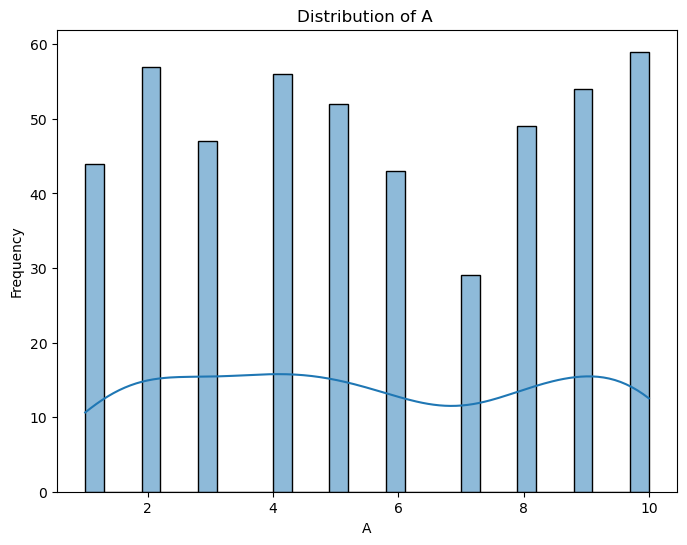

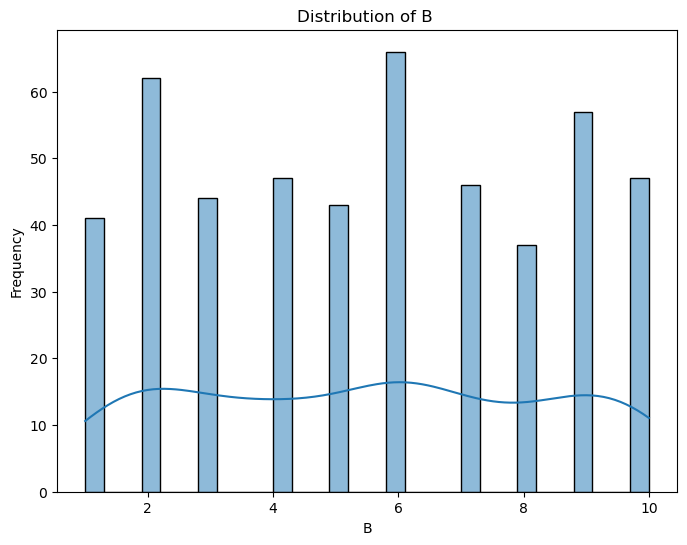

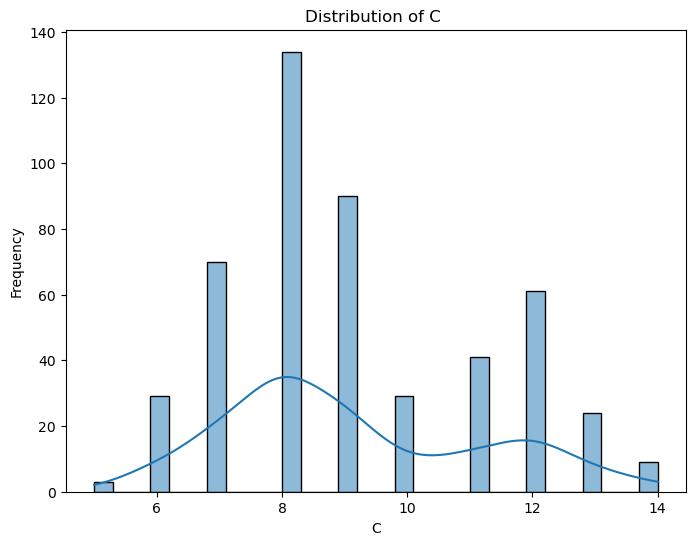

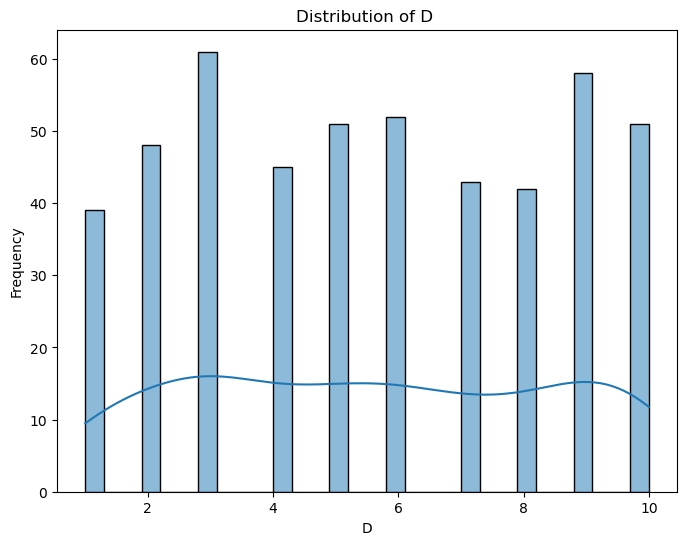

In [10]:
food_pandas= food_df.toPandas()
numeric_columns= food_pandas[["A","B","C","D"]]

for columns in numeric_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(numeric_columns[columns], kde=True, bins=30)
    plt.title(f"Distribution of {columns} ")
    plt.xlabel(f"{columns}")
    plt.ylabel("Frequency")
    plt.show()



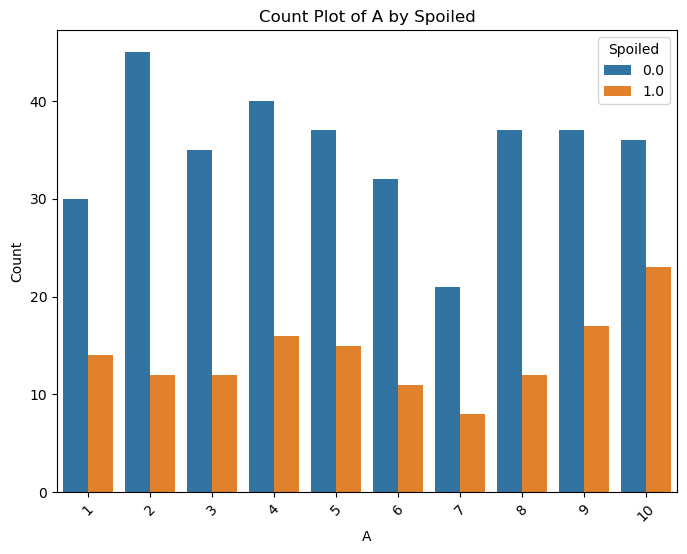

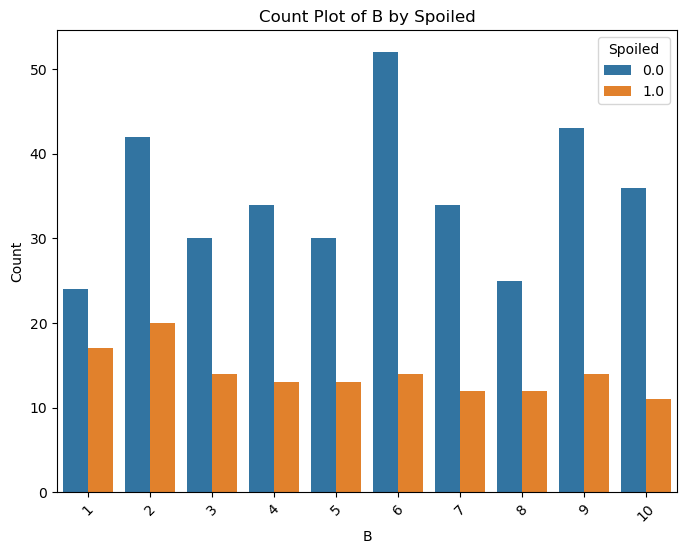

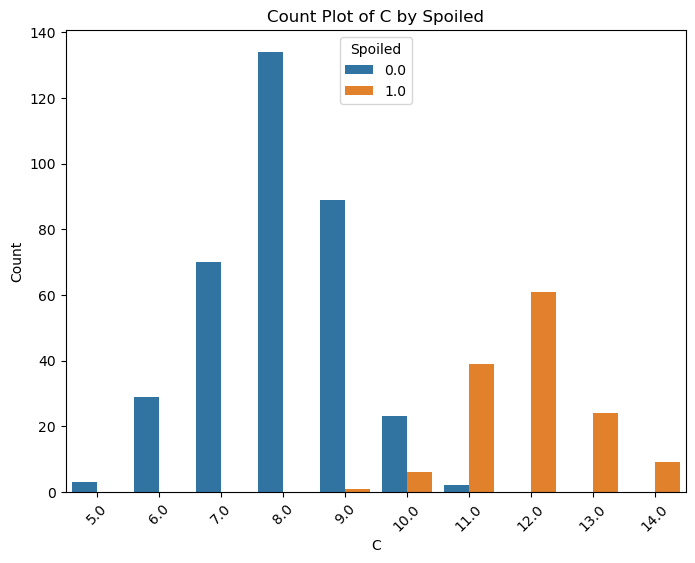

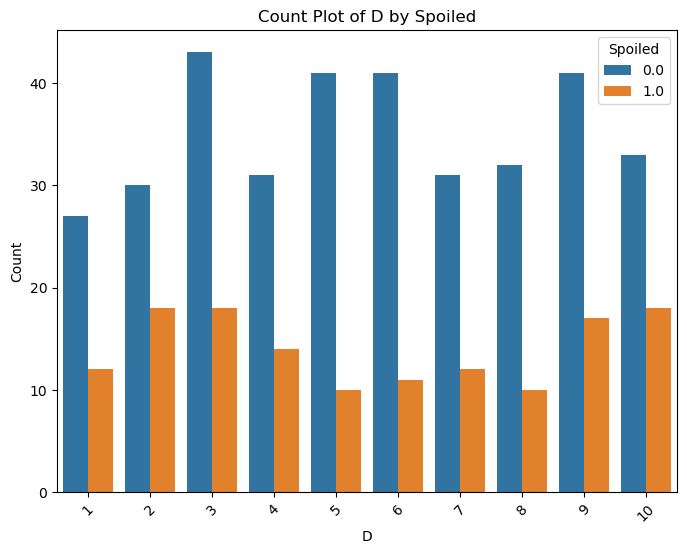

In [6]:
from pyspark.sql.functions import col
# List of features to analyze
features = ['A', 'B', 'C', 'D']
spoiled_column = 'Spoiled'

for feature in features:
    # Group by the feature and 'Spoiled' column and count
    counts = (
        food_df.groupBy(col(feature), col(spoiled_column))
        .count()
        .orderBy(col(feature), col(spoiled_column))
    )
    
    # Convert to Pandas for plotting
    counts_pd = counts.toPandas()
    
    # Plot using Seaborn
    plt.figure(figsize=(8, 6))
    sns.barplot(data=counts_pd, x=feature, y="count", hue=spoiled_column)
    plt.title(f"Count Plot of {feature} by {spoiled_column}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.legend(title=spoiled_column)
    plt.xticks(rotation=45)
    plt.show()


# MODELING

We are only going to use RANDOM FOREST

Assemble the vector 

In [7]:
from pyspark.ml.feature import VectorAssembler

#Assembler 
assembler= VectorAssembler(inputCols=features, outputCol="features")
#Transform the data with the assembler
final_data= assembler.transform(food_df)

final_data.show(5)

+---+---+----+---+-------+------------------+
|  A|  B|   C|  D|Spoiled|          features|
+---+---+----+---+-------+------------------+
|  4|  2|12.0|  3|    1.0|[4.0,2.0,12.0,3.0]|
|  5|  6|12.0|  7|    1.0|[5.0,6.0,12.0,7.0]|
|  6|  2|13.0|  6|    1.0|[6.0,2.0,13.0,6.0]|
|  4|  2|12.0|  1|    1.0|[4.0,2.0,12.0,1.0]|
|  4|  2|12.0|  3|    1.0|[4.0,2.0,12.0,3.0]|
+---+---+----+---+-------+------------------+
only showing top 5 rows



Train-test split

In [21]:
#Optional
# train, test= final_data.randomSplit([0.7,0.3])

Fit the model with the training data, then transform the test data and show the predictions

In [8]:
from pyspark.ml.classification import RandomForestClassifier

rfc= RandomForestClassifier(labelCol="Spoiled", numTrees=100)

rfc_model= rfc.fit(final_data)
rfc_preds= rfc_model.transform(final_data)
rfc_preds.toPandas().head()


,A,B,C,D,Spoiled,features,rawPrediction,probability,prediction
0,4,2,12.0,3,1.0,"[4.0, 2.0, 12.0, 3.0]","[3.439284992526852, 96.56071500747312]","[0.03439284992526853, 0.9656071500747315]",1.0
1,5,6,12.0,7,1.0,"[5.0, 6.0, 12.0, 7.0]","[5.306186454684735, 94.69381354531525]","[0.05306186454684735, 0.9469381354531526]",1.0
2,6,2,13.0,6,1.0,"[6.0, 2.0, 13.0, 6.0]","[2.695260048628736, 97.30473995137125]","[0.026952600486287365, 0.9730473995137126]",1.0
3,4,2,12.0,1,1.0,"[4.0, 2.0, 12.0, 1.0]","[3.6760643107540383, 96.32393568924596]","[0.03676064310754038, 0.9632393568924595]",1.0
4,4,2,12.0,3,1.0,"[4.0, 2.0, 12.0, 3.0]","[3.439284992526852, 96.56071500747312]","[0.03439284992526853, 0.9656071500747315]",1.0


# Evaluate predictive capability

In [9]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="Spoiled", metricName='accuracy')

print(f'RFC: {evaluator.evaluate(rfc_preds)}')
print(f"RFC F1_score: {evaluator.evaluate(rfc_preds, { evaluator.metricName: 'f1'})}")

RFC: 0.9836734693877551
RFC F1_score: 0.9836015433841521


# Feature importance

In [11]:
importance= rfc_model.featureImportances

print(f"Feature importance in RFC {importance}")


Feature importance in RFC (4,[0,1,2,3],[0.022423978951243345,0.02311488536887454,0.9291318814253036,0.025329254254578527])


There are 4 features, with index 0,1,2,3. 

Feature index 0 = A --> 0.022423978951243345

Feature index 1 = B --> 0.02311488536887454

Feature index 2 = C --> 0.9291318814253036

Feature index 3 = D --> 0.025329254254578527

Chemical C is the most important feature when predicting if the food will be spoiled, so it is highly likely that this chemical has an effect on dog food being spoiled